In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


In [3]:


# Load the dataset
file_path = '/Users/lasyatummala/Downloads/steam_store_data_2024.csv'
data = pd.read_csv(file_path)

# Preview the first few rows to understand the structure
print("Initial Data:")
print(data.head())


Initial Data:
                                               title  \
0                      Ori and the Will of the Wisps   
1  Flashing Lights - Police, Firefighting, Emerge...   
2                                         Thronefall   
3  DRAGON QUEST® XI S: Echoes of an Elusive Age™ ...   
4                                            UNDYING   

                                         description   price salePercentage  \
0  Play the critically acclaimed masterpiece. Emb...   $9.89           -67%   
1  Play solo or in up to 10-player multiplayer co...   $8.49           -66%   
2  A minimalist game about building and defending...   $5.24           -25%   
3  The Definitive Edition includes the critically...  $23.99           -40%   
4  As Anling’s zombie infection sets in, her days...  $13.99           -30%   

             recentReviews               allReviews  
0  Overwhelmingly Positive  Overwhelmingly Positive  
1            Very Positive            Very Positive  
2  Overwhelm

In [4]:
# Step 1: Handle Missing Values
# Replace missing numerical values with the mean
num_cols = data.select_dtypes(include=[np.number]).columns
data[num_cols] = data[num_cols].apply(lambda col: col.fillna(col.mean()), axis=0)

# Replace missing categorical values with the mode
cat_cols = data.select_dtypes(include=['object']).columns
data[cat_cols] = data[cat_cols].apply(lambda col: col.fillna(col.mode()[0]), axis=0)

# Step 2: Remove Duplicates
data = data.drop_duplicates()

# Step 3: Rename Columns (Optional)
# Standardize column names to lowercase and replace spaces with underscores
data.columns = [col.lower().replace(" ", "_") for col in data.columns]

# Step 4: Handle Outliers
# Remove or cap outliers in numerical columns using the IQR method
for col in num_cols:
    if data[col].nunique() > 10:  # Skip low-cardinality numeric fields
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# Step 5: Encode Categorical Data (if necessary for ML models)
# Convert categorical variables to numeric using one-hot encoding
data = pd.get_dummies(data, drop_first=True)

# Step 6: Normalize Numerical Data
# Recheck numeric columns after cleaning
num_cols = data.select_dtypes(include=[np.number]).columns

# Convert numeric-like columns to numeric and drop empty columns
for col in num_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data[num_cols] = data[num_cols].dropna(axis=1, how='all')

# Apply MinMaxScaler only if numeric columns exist
if len(num_cols) > 0:
    scaler = MinMaxScaler()
    data[num_cols] = scaler.fit_transform(data[num_cols])
    print("Scaling applied successfully.")
else:
    print("No numeric columns found for scaling.")

# Final Data Summary
print("Cleaned Data Summary:")
print(data.info())
print(data.describe())

# Save the cleaned data to a new CSV file
cleaned_file_path = '/Users/lasyatummala/Downloads/cleaned_steam_store_data.csv'
data.to_csv(cleaned_file_path, index=False)
print(f"Cleaned data saved to '{cleaned_file_path}'.")


Scaling applied successfully.
Cleaned Data Summary:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 85
Columns: 201 entries, title_And the Hero Was Never Seen Again to allreviews_Very Positive
dtypes: float64(201)
memory usage: 118.4 KB
None
       title_And the Hero Was Never Seen Again  \
count                                75.000000   
mean                                  0.013333   
std                                   0.115470   
min                                   0.000000   
25%                                   0.000000   
50%                                   0.000000   
75%                                   0.000000   
max                                   1.000000   

       title_Arms Trade Tycoon: Tanks  title_Arzette: The Jewel of Faramore  \
count                       75.000000                             75.000000   
mean                         0.013333                              0.013333   
std                          0.115470              

In [6]:
print("Dataset Columns:")
print(data.columns)


Dataset Columns:
Index(['title_And the Hero Was Never Seen Again',
       'title_Arms Trade Tycoon: Tanks',
       'title_Arzette: The Jewel of Faramore', 'title_Atomic Heart',
       'title_Banishers: Ghosts of New Eden',
       'title_Bendy and the Dark Revival', 'title_BlazBlue Entropy Effect',
       'title_Boxes: Lost Fragments', 'title_CARRION', 'title_CLeM',
       ...
       'salepercentage_-75%', 'salepercentage_-80%',
       'recentreviews_Mostly Negative', 'recentreviews_Mostly Positive',
       'recentreviews_Overwhelmingly Positive', 'recentreviews_Very Positive',
       'allreviews_Mostly Negative', 'allreviews_Mostly Positive',
       'allreviews_Overwhelmingly Positive', 'allreviews_Very Positive'],
      dtype='object', length=201)


In [7]:
# Select sale and review-related columns
selected_columns = [col for col in data.columns if 'salepercentage' in col or 'reviews' in col]

# Create a new dataframe for clustering
features = data[selected_columns]

# Ensure there are no missing values or infinities
features = features.fillna(0).replace([np.inf, -np.inf], 0)

# Preview the selected features
print("Selected Features for Clustering:")
print(features.head())


Selected Features for Clustering:
   salepercentage_-21%  salepercentage_-22%  salepercentage_-25%  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  1.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   salepercentage_-30%  salepercentage_-33%  salepercentage_-34%  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  1.0                  0.0                  0.0   

   salepercentage_-35%  salepercentage_-40%  salepercentage_-50%  \
0                  0.0                  0.0                  0.0   
1           

In [9]:

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print("Scaled Features Shape:", features_scaled.shape)


Scaled Features Shape: (75, 24)


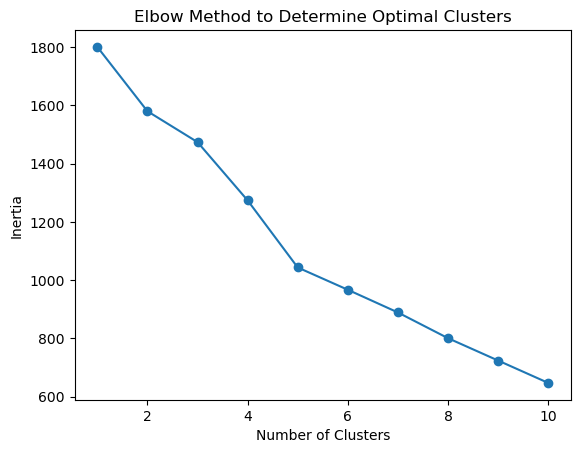

Cluster Assignments:
   cluster
0        1
1        0
2        1
3        0
4        2


In [11]:

# Determine optimal number of clusters (Elbow Method)
inertia = []
range_n_clusters = range(1, 11)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()

# Apply K-Means with the chosen number of clusters
optimal_clusters = 4  # Replace with chosen number
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(features_scaled)

print("Cluster Assignments:")
print(data[['cluster']].head())


Cluster Analysis:
         title_And the Hero Was Never Seen Again  \
cluster                                            
0                                       0.014706   
1                                       0.000000   
2                                       0.000000   
3                                       0.000000   

         title_Arms Trade Tycoon: Tanks  title_Arzette: The Jewel of Faramore  \
cluster                                                                         
0                              0.014706                              0.014706   
1                              0.000000                              0.000000   
2                              0.000000                              0.000000   
3                              0.000000                              0.000000   

         title_Atomic Heart  title_Banishers: Ghosts of New Eden  \
cluster                                                            
0                  0.014706                   

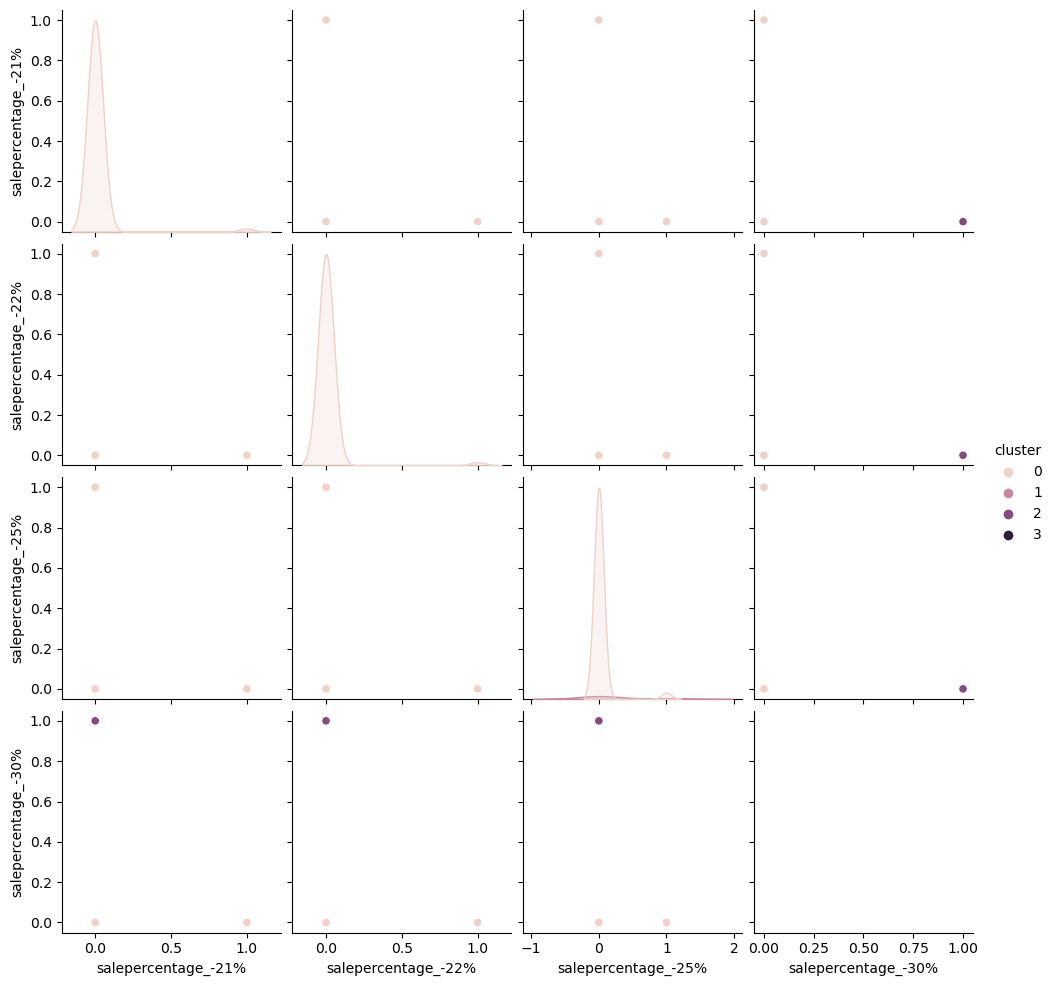

In [12]:
# Analyze clusters
cluster_analysis = data.groupby('cluster').mean()
print("Cluster Analysis:")
print(cluster_analysis)

# Optional: Visualize clusters using a pairplot
import seaborn as sns
sns.pairplot(data, hue='cluster', vars=selected_columns[:4])  # Use first few columns for visualization
plt.show()


In [13]:
# Analyze cluster statistics
cluster_analysis = data.groupby('cluster').mean()

# Display cluster patterns
print("Cluster Analysis:")
print(cluster_analysis)


Cluster Analysis:
         title_And the Hero Was Never Seen Again  \
cluster                                            
0                                       0.014706   
1                                       0.000000   
2                                       0.000000   
3                                       0.000000   

         title_Arms Trade Tycoon: Tanks  title_Arzette: The Jewel of Faramore  \
cluster                                                                         
0                              0.014706                              0.014706   
1                              0.000000                              0.000000   
2                              0.000000                              0.000000   
3                              0.000000                              0.000000   

         title_Atomic Heart  title_Banishers: Ghosts of New Eden  \
cluster                                                            
0                  0.014706                   

In [14]:
# Define personas based on analysis
cluster_to_persona = {
    0: 'Discount Seekers',
    1: 'Positive Review Enthusiasts',
    2: 'Mixed Sentiment Gamers',
    3: 'Neutral Buyers'  # Example for an additional cluster
}

# Assign personas to clusters
data['persona'] = data['cluster'].map(cluster_to_persona)

# Display data with personas
print("Data with Personas:")
print(data[['cluster', 'persona']].head())


Data with Personas:
   cluster                      persona
0        1  Positive Review Enthusiasts
1        0             Discount Seekers
2        1  Positive Review Enthusiasts
3        0             Discount Seekers
4        2       Mixed Sentiment Gamers


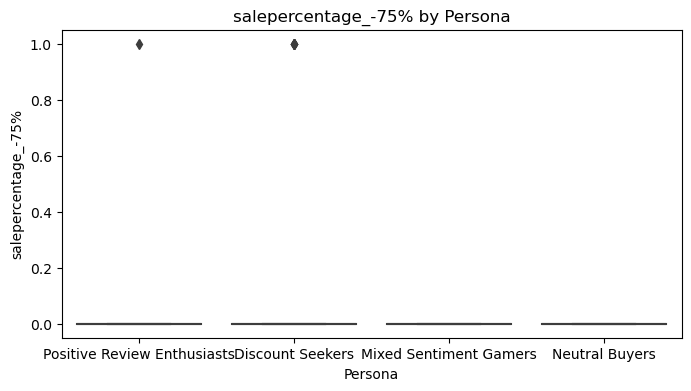

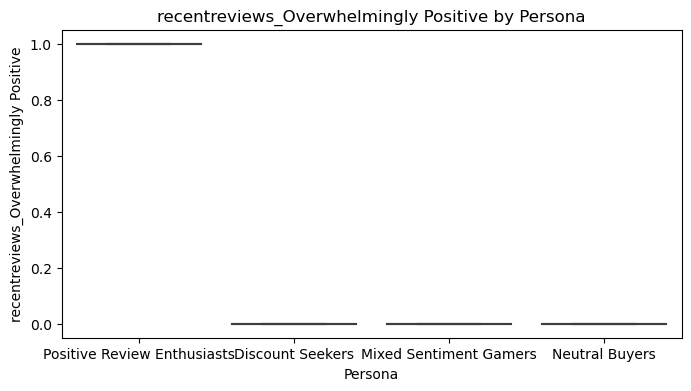

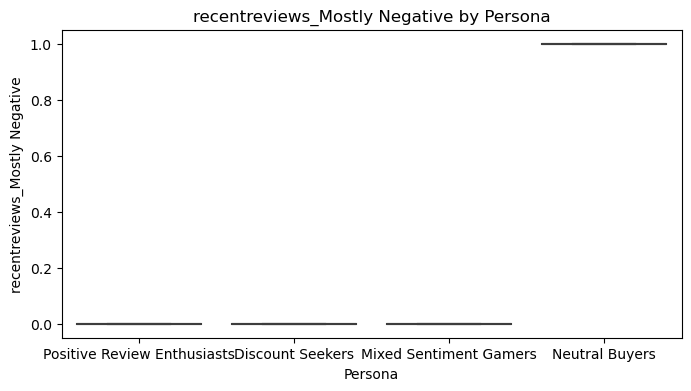

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot cluster patterns for key features
key_features = ['salepercentage_-75%', 'recentreviews_Overwhelmingly Positive', 'recentreviews_Mostly Negative']
for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='persona', y=feature, data=data)
    plt.title(f'{feature} by Persona')
    plt.xlabel('Persona')
    plt.ylabel(feature)
    plt.show()


In [16]:
# Save the dataset with personas
data.to_csv('steam_persona_data.csv', index=False)
print("Dataset with personas saved as 'steam_persona_data.csv'.")


Dataset with personas saved as 'steam_persona_data.csv'.


In [18]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2'])
pca_df['cluster'] = data['cluster']  # Add cluster assignments

print("Explained Variance Ratio by PCA Components:", pca.explained_variance_ratio_)


Explained Variance Ratio by PCA Components: [0.18584761 0.11468547]


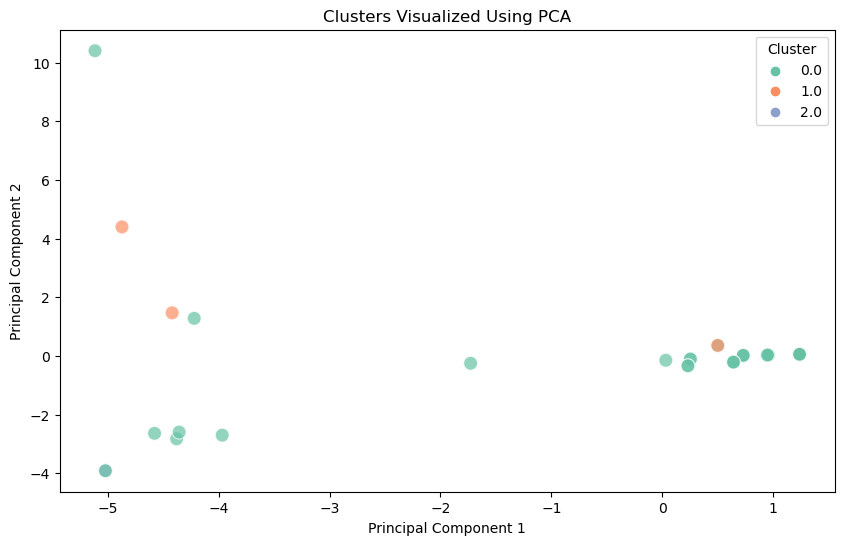

In [19]:
# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PC1', y='PC2', hue='cluster', data=pca_df, palette='Set2', s=100, alpha=0.7
)
plt.title('Clusters Visualized Using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


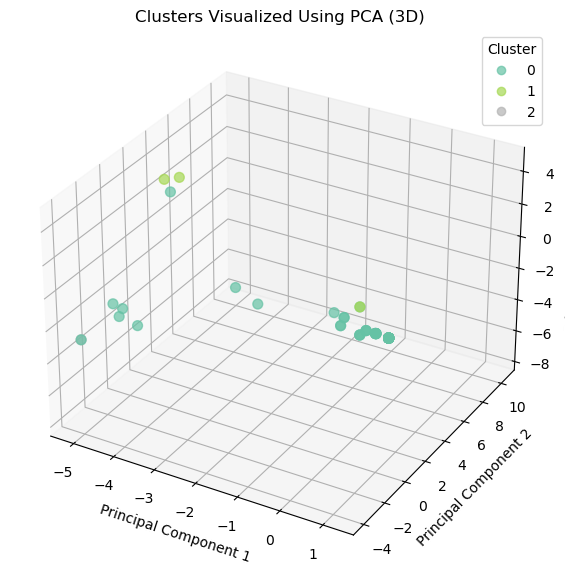

In [21]:

# Apply PCA to reduce to 3 dimensions
pca_3d = PCA(n_components=3)
pca_features_3d = pca_3d.fit_transform(features_scaled)

# Create a DataFrame for PCA 3D results
pca_df_3d = pd.DataFrame(data=pca_features_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['cluster'] = data['cluster']

# Plot in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_df_3d['PC1'], pca_df_3d['PC2'], pca_df_3d['PC3'],
    c=pca_df_3d['cluster'], cmap='Set2', s=50, alpha=0.7
)
ax.set_title('Clusters Visualized Using PCA (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


In [23]:
# Add descriptive statistics for each cluster
cluster_stats = data.groupby('cluster').agg(['mean', 'median', 'std', 'count'])

print("Cluster Summary Statistics:")
print(cluster_stats)


Cluster Summary Statistics:
        title_And the Hero Was Never Seen Again                         \
                                           mean median       std count   
cluster                                                                  
0                                      0.014706    0.0  0.121268    68   
1                                      0.000000    0.0  0.000000     5   
2                                      0.000000    0.0       NaN     1   
3                                      0.000000    0.0       NaN     1   

        title_Arms Trade Tycoon: Tanks                         \
                                  mean median       std count   
cluster                                                         
0                             0.014706    0.0  0.121268    68   
1                             0.000000    0.0  0.000000     5   
2                             0.000000    0.0       NaN     1   
3                             0.000000    0.0       NaN     1  

/var/folders/fp/drm5pw1d13x1n4wvd2q14v0m0000gn/T/ipykernel_23573/1381658004.py:2: FutureWarning: ['persona'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  cluster_stats = data.groupby('cluster').agg(['mean', 'median', 'std', 'count'])


/var/folders/fp/drm5pw1d13x1n4wvd2q14v0m0000gn/T/ipykernel_23573/520813841.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to prevent overlap


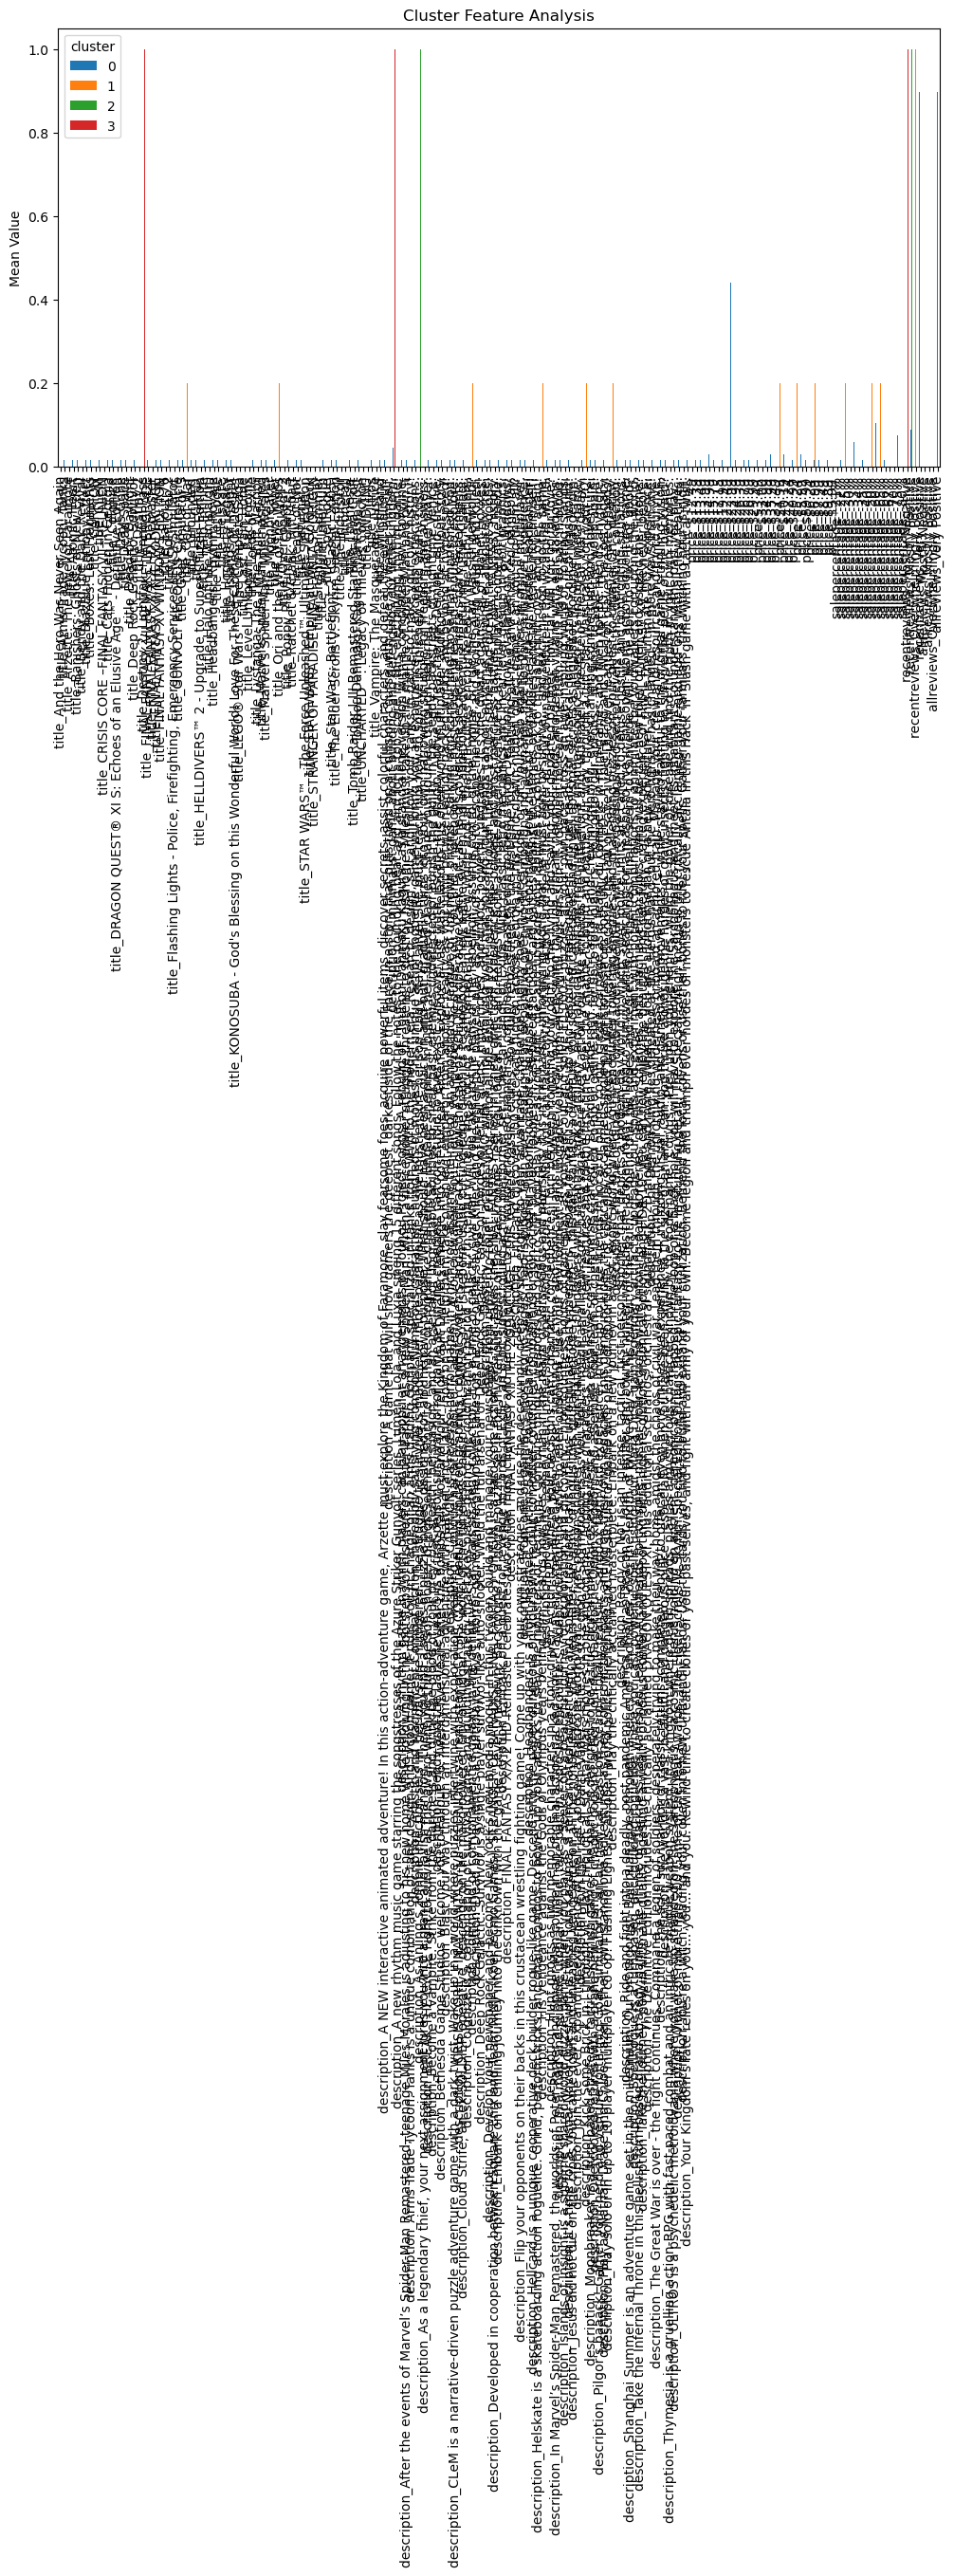

In [26]:
# Adjust the bar plot to rotate x-axis labels
cluster_analysis.T.plot(kind='bar', figsize=(12, 6), legend=True)
plt.title('Cluster Feature Analysis')
plt.ylabel('Mean Value')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


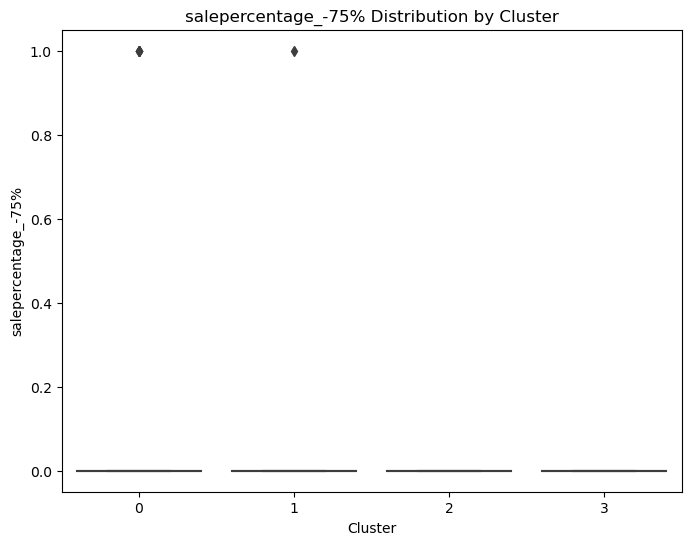

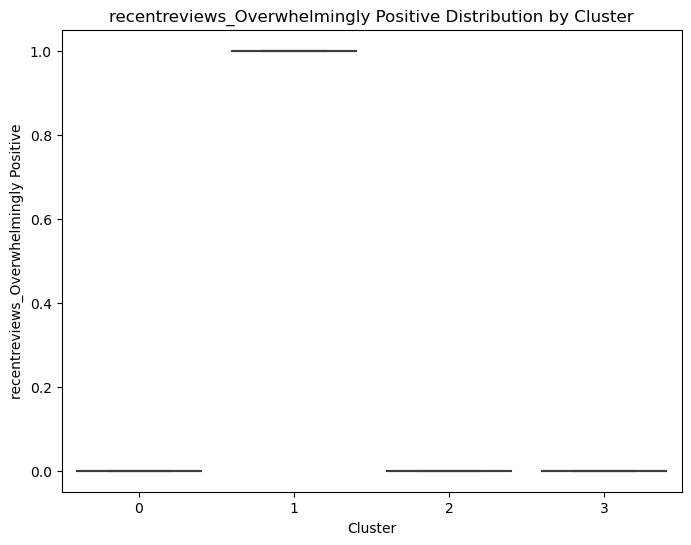

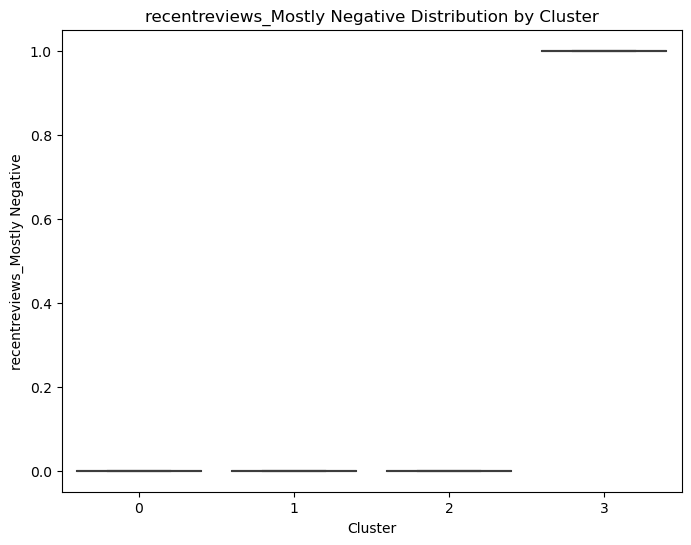

In [27]:
import seaborn as sns

# Plot distributions for individual features
for feature in key_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='cluster', y=feature, data=data)
    plt.title(f'{feature} Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()


In [29]:
# Save the updated cluster feature analysis chart
plt.savefig('cluster_feature_analysis_updated.png', dpi=300)


<Figure size 640x480 with 0 Axes>